# 프로젝트: 영화 시놉시스 데이터를 활용한 장르 간 편향성 측정

#### **프로젝트 개요**

**1. 프로젝트 목적:**

   영화 시놉시스 텍스트 데이터를 기반으로 Word Embedding 모델을 학습하고, WEAT(Word Embedding Association Test) 기법을 활용하여 영화 장르 간 내재된 편향성을 정량적으로 측정하는 것을 목표로 한다. 이를 통해 2개 영화 구분(예술영화/일반영화)과 21개 장르(예: 액션, 로맨스, 스릴러 등) 사이의 암묵적 연관 패턴을 분석한다.          



**2. 데이터셋: [KOBIS 개봉 영화 데이터](https://www.kobis.or.kr/kobis/business/stat/offc/searchOfficHitTotList.do?searchMode=month)**  

2001년부터 2019년 8월까지 개봉한 국내외 영화 중 일부의 시놉시스와 장르 정보를 코퍼스 형태로 가공하여 사용한다.  


- 영화 구분
  * `synopsis_art.txt` : 예술영화
  * `synopsis_gen.txt` : 일반영화(상업영화)
  * 그 외는 독립영화 등으로 분류됨


    
- 영화 장르
    * `synopsis_SF.txt`: SF
    * `synopsis_가족.txt`: 가족
    * `synopsis_공연.txt`: 공연
    * `synopsis_공포(호러).txt`: 공포(호러)
    * `synopsis_기타.txt`: 기타
    * `synopsis_다큐멘터리.txt`: 다큐멘터리
    * `synopsis_드라마.txt`: 드라마
    * `synopsis_멜로로맨스.txt`: 멜로로맨스
    * `synopsis_뮤지컬.txt`: 뮤지컬
    * `synopsis_미스터리.txt`: 미스터리
    * `synopsis_범죄.txt`: 범죄
    * `synopsis_사극.txt`: 사극
    * `synopsis_서부극(웨스턴).txt`: 서부극
    * `synopsis_성인물(에로).txt`: 성인물
    * `synopsis_스릴러.txt`: 스릴러
    * `synopsis_애니메이션.txt`: 애니메이션
    * `synopsis_액션.txt`: 액션
    * `synopsis_어드벤처.txt`: 어드벤처
    * `synopsis_전쟁.txt`: 전쟁
    * `synopsis_코미디.txt`: 코미디
    * `synopsis_판타지.txt`: 판타지        


**3. 임베딩 모델: Word2Vec**  
- **알고리즘**: CBOW (Continuous Bag of Words)
- **라이브러리**: Gensim 4.0
- **선정 이유**:
  - 학습 속도 Skip-gram보다 빠름 (중규모 코퍼스에 적합)
  - 자주 등장하는 단어에 대해 안정적인 임베딩 생성
  - 영화 시놉시스는 일반적인 어휘가 반복되므로 CBOW가 효율적        

**4. 평가 지표: WEAT Score (Word Embedding Association Test)**  

WEAT는 2017년 Caliskan et al.이 제안한 방법론으로, 단어 임베딩 공간에서 특정 개념 간 암묵적 연관성을 측정한다. 심리학의 IAT(Implicit Association Test)를 NLP에 적용한 것이다.  

$$
\text{WEAT\ Score}=\frac{\text{mean}_{x\in X}s(x,A,B)-\text{mean}_{y\in Y}s(y,A,B)}{\text{std}_{w\in X\cup Y}s(w,A,B)}
$$  


- **X, Y**: 편향을 측정하려는 대상 개념 (Target 집합)
- **A, B**: 그 대상과 연결된 속성 또는 가치 (Attribute 집합)
- **cos(w, a)**: 단어 w와 a의 임베딩 벡터 간 코사인 유사도
    

WEAT Score를 해석하는 방법은 다음과 같다.
- 값의 부호:
    - **양수 (+)**: 타겟 X가 속성 A와, 타겟 Y가 속성 B와 더 밀접함
    - **음수 (-)**: 타겟 X가 속성 B와, 타겟 Y가 속성 A와 더 밀점함
    
- 효과 크기:
  - 절댓값이 클수록 두 집합 간의 편향이 뚜렷함을 의미한다.
  - 일반적으로 Cohen's d 기준을 준용하여 0.2는 작은 효과, 0.5는 중간, 0.8 이상은 큰 효과로 해석한다.
    
- 통계적 유의성:

  Score와 함께 순열 검정(Permutation Test)을 통해 산출된 **p-value**를 확인해야 한다. 일반적으로 \(p<0.05\)일 때, 해당 편향이 통계적으로 유의미하다고 결론짓는다.          

**5. 프로젝트 수행 절차**  
```
영화 시놉시스 코퍼스 (영화 종류 구분 파일 2개 + 장르 구분 파일 21개)
         ↓
[STEP 1] 형태소 분석 (명사 추출)
         ↓
[STEP 2] Word2Vec 모델 학습
         ↓
[STEP 3] 대표 단어 셋 구축
         ↓
[STEP 4] WEAT Score 계산 및 시각화
```

## STEP 0. 라이브러리 & 데이터 불러오기

In [1]:
# NLP libraries
from konlpy.tag import Okt
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer

# Helper libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
from collections import Counter
from multiprocessing import Pool, cpu_count
from functools import partial
import tqdm
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

In [2]:
# 경로 설정
data_dir = os.path.join(os.getenv("HOME"), "work/weat/data")

In [3]:
# Target 집합 파일 (예술영화 vs 일반영화)
art_txt = 'synopsis_art.txt'
gen_txt = 'synopsis_gen.txt'

# Attribute 집합 파일 (장르별)
genre_txt = ['synopsis_SF.txt', 'synopsis_family.txt', 'synopsis_show.txt', 'synopsis_horror.txt', 'synopsis_etc.txt',
             'synopsis_documentary.txt', 'synopsis_drama.txt', 'synopsis_romance.txt', 'synopsis_musical.txt',
             'synopsis_mystery.txt', 'synopsis_crime.txt', 'synopsis_historical.txt', 'synopsis_western.txt',
             'synopsis_adult.txt', 'synopsis_thriller.txt', 'synopsis_animation.txt', 'synopsis_action.txt',
             'synopsis_adventure.txt', 'synopsis_war.txt', 'synopsis_comedy.txt', 'synopsis_fantasy.txt']

genre_name = ['SF', '가족', '공연', '공포(호러)', '기타', '다큐멘터리', '드라마', '멜로로맨스', '뮤지컬', '미스터리', 
              '범죄', '사극', '서부극(웨스턴)', '성인물(에로)', '스릴러', '애니메이션', '액션', '어드벤처', '전쟁', 
              '코미디', '판타지']

In [4]:
print("="*60)
print("Target 집합 데이터 로드 중...")
print("="*60)

# 예술영화 데이터 읽기
with open(os.path.join(data_dir, art_txt), 'r', encoding='utf-8') as f:
    art_data = f.read().strip().split('\n')

# 일반영화 데이터 읽기
with open(os.path.join(data_dir, gen_txt), 'r', encoding='utf-8') as f:
    gen_data = f.read().strip().split('\n')

print(f"예술영화 시놉시스 수: {len(art_data)}")
print(f"일반영화 시놉시스 수: {len(gen_data)}")

Target 집합 데이터 로드 중...
예술영화 시놉시스 수: 14435
일반영화 시놉시스 수: 48116


In [5]:
print("\n" + "="*60)
print("Attribute 집합 데이터 로드 중...")
print("="*60)

genre = []
for file_name in genre_txt:
    file_path = os.path.join(data_dir, file_name)
    with open(file_path, 'r', encoding='utf-8') as f:
        genre.append(f.read().strip().split('\n'))

print(f"총 {len(genre)}개 장르 로드 완료")
for i, g in enumerate(genre):
    print(f"  {genre_name[i]}: {len(g)}개 시놉시스")


Attribute 집합 데이터 로드 중...
총 21개 장르 로드 완료
  SF: 1023개 시놉시스
  가족: 422개 시놉시스
  공연: 346개 시놉시스
  공포(호러): 3088개 시놉시스
  기타: 3687개 시놉시스
  다큐멘터리: 7147개 시놉시스
  드라마: 19229개 시놉시스
  멜로로맨스: 5776개 시놉시스
  뮤지컬: 170개 시놉시스
  미스터리: 1078개 시놉시스
  범죄: 1694개 시놉시스
  사극: 239개 시놉시스
  서부극(웨스턴): 48개 시놉시스
  성인물(에로): 1647개 시놉시스
  스릴러: 2265개 시놉시스
  애니메이션: 8779개 시놉시스
  액션: 5860개 시놉시스
  어드벤처: 535개 시놉시스
  전쟁: 387개 시놉시스
  코미디: 4635개 시놉시스
  판타지: 801개 시놉시스


## STEP 1. 형태소 분석기를 이용하여 품사가 명사인 경우 해당 단어를 추출하기

In [6]:
print("\n" + "="*60)
print("형태소 분석 시작...")
print("="*60)

okt = Okt()

# 예술영화 명사 추출
print("예술영화 형태소 분석 중...")
art_nouns = [okt.nouns(text) for text in art_data]

# 일반영화 명사 추출
print("일반영화 형태소 분석 중...")
gen_nouns = [okt.nouns(text) for text in gen_data]

# 장르별 명사 추출
genre_nouns = []
for i, g in enumerate(genre):
    print(f"{genre_name[i]} 형태소 분석 중... ({i+1}/{len(genre)})")
    nouns = [okt.nouns(text) for text in g]
    genre_nouns.append(nouns)

print("\n형태소 분석 완료!")


형태소 분석 시작...
예술영화 형태소 분석 중...
일반영화 형태소 분석 중...
SF 형태소 분석 중... (1/21)
가족 형태소 분석 중... (2/21)
공연 형태소 분석 중... (3/21)
공포(호러) 형태소 분석 중... (4/21)
기타 형태소 분석 중... (5/21)
다큐멘터리 형태소 분석 중... (6/21)
드라마 형태소 분석 중... (7/21)
멜로로맨스 형태소 분석 중... (8/21)
뮤지컬 형태소 분석 중... (9/21)
미스터리 형태소 분석 중... (10/21)
범죄 형태소 분석 중... (11/21)
사극 형태소 분석 중... (12/21)
서부극(웨스턴) 형태소 분석 중... (13/21)
성인물(에로) 형태소 분석 중... (14/21)
스릴러 형태소 분석 중... (15/21)
애니메이션 형태소 분석 중... (16/21)
액션 형태소 분석 중... (17/21)
어드벤처 형태소 분석 중... (18/21)
전쟁 형태소 분석 중... (19/21)
코미디 형태소 분석 중... (20/21)
판타지 형태소 분석 중... (21/21)

형태소 분석 완료!


In [7]:
print("\n=== 형태소 분석 결과 확인 ===")

# 예술영화 첫 3개 문서
print("\n[예술영화 샘플]")
for i in range(min(3, len(art_nouns))):
    print(f"문서 {i+1}: {art_nouns[i][:10]}")  # 앞 10개만

# 일반영화 첫 3개 문서
print("\n[일반영화 샘플]")
for i in range(min(3, len(gen_nouns))):
    print(f"문서 {i+1}: {gen_nouns[i][:10]}")

# 각 장르 첫 문서
print("\n[장르별 샘플]")
for i, nouns in enumerate(genre_nouns):
    print(f"{genre_name[i]}: {nouns[0][:10]}")


=== 형태소 분석 결과 확인 ===

[예술영화 샘플]
문서 1: ['사운드', '엔지니어', '상우', '유지태', '분', '치매', '할머니', '백성희', '분']
문서 2: ['시절', '상처', '아버지', '박인환', '분', '고모', '신신애', '분', '살']
문서 3: ['겨울', '그', '지방', '방송국', '라디오', '은수', '이영애', '분', '를']

[일반영화 샘플]
문서 1: ['유사', '연령', '성별', '빈부', '차이', '정치', '입장', '불문', '국민', '통합']
문서 2: ['민족', '국가', '란', '공동체', '권력', '자', '민족', '국가', '란', '공동체']
문서 3: ['엽기', '살인', '사건', '발생', '장소', '관광', '투어', '팀', '그', '팀']

[장르별 샘플]
SF: ['시간', '지명', '알', '수', '한국', '가상', '도시', '산성비', '오염', '이']
가족: ['모든', '장난감', '가장', '일', '바로', '주인', '더', '이상', '자신', '것']
공연: ['과학자', '빅터', '프랑켄슈타인', '박사', '생명', '비밀', '인간', '형상', '피조', '물']
공포(호러): ['대학', '생활', '카', '시마', '료', '스케', '가토', '하루히', '코', '분']
기타: ['바닷가', '집', '남편', '딸', '살', '나', '남편', '딸', '잠시', '집']
다큐멘터리: ['유사', '연령', '성별', '빈부', '차이', '정치', '입장', '불문', '국민', '통합']
드라마: ['사운드', '엔지니어', '상우', '유지태', '분', '치매', '할머니', '백성희', '분']
멜로로맨스: ['관광', '투어', '버스', '가이드', '일', '시작', '얼마', '아오이', '성적', '성격']
뮤지컬: ['뮤지컬', '헤드윅', '의', '탄생', '공연', '영화

In [8]:
print("\n=== 빈도수 TOP 20 명사 확인 ===")

# 예술영화 TOP 20
art_all_nouns = [noun for doc in art_nouns for noun in doc]
art_counter = Counter(art_all_nouns)
print("\n[예술영화]")
for word, count in art_counter.most_common(20):
    print(f"  {word}: {count}회")

# 일반영화 TOP 20
gen_all_nouns = [noun for doc in gen_nouns for noun in doc]
gen_counter = Counter(gen_all_nouns)
print("\n[일반영화]")
for word, count in gen_counter.most_common(20):
    print(f"  {word}: {count}회")

# 각 장르 TOP 10
print("\n[장르별 TOP 10]")
for i, nouns in enumerate(genre_nouns):
    all_nouns = [noun for doc in nouns for noun in doc]
    counter = Counter(all_nouns)
    top_words = [word for word, _ in counter.most_common(10)]
    print(f"{genre_name[i]}: {top_words}")


=== 빈도수 TOP 20 명사 확인 ===

[예술영화]
  그: 3661회
  것: 1762회
  수: 1710회
  그녀: 1677회
  자신: 1625회
  이: 1613회
  시작: 1607회
  위해: 1438회
  사랑: 1404회
  사람: 1291회
  날: 1283회
  의: 872회
  영화: 863회
  친구: 835회
  두: 806회
  남자: 739회
  속: 730회
  알: 724회
  집: 700회
  은: 661회

[일반영화]
  그: 19060회
  것: 10143회
  이: 8461회
  자신: 7952회
  그녀: 7567회
  영화제: 7563회
  제: 7121회
  수: 6852회
  위해: 6197회
  사람: 5589회
  시작: 5549회
  국제: 5151회
  날: 5049회
  영화: 4606회
  집: 4155회
  친구: 4141회
  사랑: 4100회
  남자: 3814회
  알: 3524회
  속: 3366회

[장르별 TOP 10]
SF: ['그', '것', '수', '위해', '자신', '이', '시작', '지구', '사람', '알']
가족: ['그', '것', '엄마', '수', '집', '영화제', '아빠', '자신', '가족', '이']
공연: ['그', '사랑', '이', '자신', '오페라', '그녀', '알', '위해', '공연', '돈']
공포(호러): ['그', '것', '수', '이', '시작', '위해', '사람', '자신', '집', '친구']
기타: ['제', '영화제', '국제', '그', '서울', '단편', '것', '이', '자신', '초']
다큐멘터리: ['그', '이', '영화제', '제', '것', '영화', '국제', '사람', '수', '다큐멘터리']
드라마: ['그', '것', '자신', '영화제', '그녀', '제', '이', '수', '날', '사람']
멜로로맨스: ['그', '그녀', '사랑', '자신', '날', '것', '시작', '남자', '

⚠️ 형태소 분석 결과로 추출된 장르별 상위 20개 명사 목록을 볼 때, 다음과 같은 문제점을 발견했다.

- '그', '것', '이', '수', '자신' 등 대명사와 조사가 모든 장르 TOP 10을 차지
- 21개 장르 중 20개 이상에서 공통적으로 등장하는 단어가 50% 이상
- 이로 인해 장르 고유 단어, 예를 들어 사극 장르의 '조선'이나 '왕' 같은 특징적 단어들이 하위권으로 밀려남

만약 현재 빈도수 상위 20개 명사를 그대로 Attribute 집합으로 구성하면, 장르 간 공통 단어가 과도하게 많아 WEAT Score 계산 시 두 장르의 차이를 제대로 측정할 수 없게 될 것이다.

## STEP 2. 추출된 결과로 임베딩 모델 만들기

In [9]:
# 모든 문서를 하나로 합치기
all_corpus = []

# 예술영화/일반영화 추가
all_corpus.extend(art_nouns)
all_corpus.extend(gen_nouns)

# 장르별 추가
for nouns in genre_nouns:
    all_corpus.extend(nouns)

print(f"전체 문서 수: {len(all_corpus)}")

전체 문서 수: 131407


In [10]:
# Word2Vec 모델 학습
w2v_model = Word2Vec(sentences=all_corpus,
                     vector_size=100,
                     window=5,
                     min_count=3, # 총 단어 수가 많아 최소 빈도수 3으로 향상
                     workers=4,
                     sg=0,
                     epochs=10,
                     seed=42) # 재현성을 위해 seed 고정 

print(f"모델 학습 완료! 어휘 크기: {len(w2v_model.wv)}")

모델 학습 완료! 어휘 크기: 30026


In [11]:
# 모델 테스트
test_words = ['사랑', '액션', '감동']

for word in test_words:
    if word in w2v_model.wv:
        similar = w2v_model.wv.most_similar(word, topn=10)
        print(f"{word}: {[w for w, _ in similar]}")

사랑: ['진심', '행복', '애정', '키스', '연인', '재회', '우정', '집착', '삼각관계', '만남']
액션: ['블록버스터', '무협', '고어', '호러', '어드벤처', '스릴러', '대작', '슬래셔', '호러영화', '시대극']
감동: ['선사', '울림', '시적', '희극', '흥미진진', '뮤지컬', '스토리', '생동감', '휴먼', '영화로']


## STEP 3. target, attribute 단어 집합 만들기

In [12]:
# TF-IDF로 Target 집합 대표 단어 선택
print("\n" + "="*60)
print("Target 집합 대표 단어 추출 중...")
print("="*60)

# 예술영화/일반영화를 각각 하나의 문서로 변환
art_doc = ' '.join([' '.join(nouns) for nouns in art_nouns])
gen_doc = ' '.join([' '.join(nouns) for nouns in gen_nouns])

# TF-IDF 계산
vectorizer_target = TfidfVectorizer(max_features=500, min_df=1)
X_target = vectorizer_target.fit_transform([art_doc, gen_doc])

top_n = 30
max_overlap = 2  # 최대 허용 중복 개수

# 예술영화 TF-IDF 점수
art_tfidf = X_target[0].toarray()[0]
art_top_indices = art_tfidf.argsort()[-50:][::-1]  # 넉넉하게 50개 추출
words_target = vectorizer_target.get_feature_names_out()

# 예술영화 대표 단어 (먼저 선택)
art_keywords = []
for idx in art_top_indices:
    word = words_target[idx]
    if word in w2v_model.wv and len(word) > 1 and len(art_keywords) < top_n:
        art_keywords.append(word)

# 일반영화 TF-IDF 점수
gen_tfidf = X_target[1].toarray()[0]
gen_top_indices = gen_tfidf.argsort()[-50:][::-1]

# 일반영화 대표 단어 (중복 제한적 허용)
gen_keywords = []
overlap_count = 0  # 현재 중복 개수 추적

for idx in gen_top_indices:
    word = words_target[idx]
    
    if word not in w2v_model.wv or len(word) <= 1:
        continue
    
    # 중복 확인
    if word in art_keywords:
        if overlap_count < max_overlap:
            # 허용 범위 내 중복
            gen_keywords.append(word)
            overlap_count += 1
        # else: 넘어감 (더 이상 중복 허용 안 함)
    else:
        # 중복이 안되면 바로 추가
        gen_keywords.append(word)
    
    if len(gen_keywords) >= top_n:
        break

print(f"예술영화 대표 단어 ({len(art_keywords)}개): {art_keywords[:10]}")
print(f"일반영화 대표 단어 ({len(gen_keywords)}개): {gen_keywords[:10]}")

# 중복 확인
overlap_words = set(art_keywords) & set(gen_keywords)
print(f"\n중복 단어 ({len(overlap_words)}개): {list(overlap_words)}")
print(f"중복 비율: {len(overlap_words)/top_n*100:.1f}%")


Target 집합 대표 단어 추출 중...
예술영화 대표 단어 (30개): ['그녀', '자신', '시작', '위해', '사랑', '사람', '영화', '친구', '남자', '가족']
일반영화 대표 단어 (22개): ['자신', '그녀', '영화제', '국제', '서울', '남편', '단편', '사실', '세계', '모습']

중복 단어 (2개): ['자신', '그녀']
중복 비율: 6.7%


In [13]:
# 예술영화 대표 단어 (30개): ['그녀', '자신', '시작', '위해', '사랑', '사람', '영화', '친구', '남자', '가족', '이야기', '마을', '사건', '마음', '세상', '아버지', '아이', '엄마', '모든', '여자']
# 일반영화 대표 단어 (30개): ['자신', '그녀', '영화제', '위해', '사람', '시작', '국제', '영화', '친구', '사랑', '남자', '이야기', '대한', '서울', '여자', '사건', '남편', '아이', '가족', '아버지']

예술영화와 일반영화의 대표 단어는 기본 TF-IDF를 사용하여 선정했을 때 중복되는 단어가 너무 많았다 (위 주석 셀 참고). 이 때문에 중복을 제거해 두 집합 간 차별성을 두어 명확히 구별되도록 할 필요가 있었다.  
구체적으로는 예술영화에서 TF-IDF 상위 30개 단어를 먼저 선택한 후, 일반영화는 중복 단어 수를 최대 2개로 제한하며 TF-IDF 상위 30개를 선택했다.

In [14]:
# TF-IDF로 Attribute 집합 대표 단어 선택
print("\n" + "="*60)
print("Attribute 집합 대표 단어 추출 중...")
print("="*60)


# 각 장르를 하나의 문서로 변환
genre_docs = []
for nouns in genre_nouns:
    doc = ' '.join([' '.join(n) for n in nouns])
    genre_docs.append(doc)


# 전체 장르에 대해 TF-IDF 계산
vectorizer_genre = TfidfVectorizer(
    max_features=500,
    min_df=2
)

X_genre = vectorizer_genre.fit_transform(genre_docs)
feature_names = vectorizer_genre.get_feature_names_out()

top_n_genre = 20
genre_keywords = {}

# 중복 확인
word_usage_count = {}  # 각 단어가 몇 개 장르에서 선택되었는지 추적
max_allowed_usage = 2  # 최대 2개 장르까지 허용


# 각 장르별로 고유 대표 단어 추출
for i in range(len(genre_name)):
    
    # 해당 장르의 TF-IDF 점수 추출
    genre_tfidf = X_genre[i].toarray()[0]
    
    # 다른 장르들의 평균 TF-IDF 계산
    other_indices = [j for j in range(len(genre_name)) if j != i]
    other_tfidf = X_genre[other_indices].toarray().mean(axis=0)
    
    # Uniqueness Score 계산
    uniqueness = genre_tfidf / (other_tfidf + 1e-10)
    
    # 최종 점수 계산
    final_scores = genre_tfidf * uniqueness
    
    # 단어와 점수를 함께 저장
    word_scores = [
        (feature_names[idx],
         genre_tfidf[idx],
         uniqueness[idx],
         final_scores[idx])
        for idx in range(len(feature_names))
    ]
    
    word_scores.sort(key=lambda x: x[3], reverse=True)
    
    # 상위 단어 선택 (중복 제한적 허용)
    selected = []
    
    for word, tfidf, uniq, final in word_scores:
        # 선택 조건:
        # 1. Word2Vec 모델에 존재함
        # 2. 1글자 초과
        # 3. 아직 2개 장르에서만 사용됨 (또는 미사용)
        # 4. 아직 top_n개를 채우지 않음
        
        if (word in w2v_model.wv and 
            len(word) > 1 and 
            word_usage_count.get(word, 0) < max_allowed_usage and  # 🔑 중복 제한
            len(selected) < top_n_genre):
            
            selected.append(word)
            
            # 사용 횟수 증가
            word_usage_count[word] = word_usage_count.get(word, 0) + 1
    
    genre_keywords[genre_name[i]] = selected
    
    # 개선 효과 출력
    basic_top5 = [feature_names[idx] 
                  for idx in genre_tfidf.argsort()[-5:][::-1]]
    improved_top5 = selected[:5]
    
    print(f"\n{genre_name[i]}:")
    print(f"  기본 방식: {basic_top5}") # 기본 TF-IDF 방식과 비교
    print(f"  개선 방식: {improved_top5}")


# 개선 효과 확인
print("\n" + "="*60)
print("개선 효과 요약")
print("="*60)

from collections import Counter

# 기본 방식과 개선 방식의 단어 목록 수집
basic_words = []
improved_words = []

for i in range(len(genre_name)):
    tfidf_scores = X_genre[i].toarray()[0]
    top_indices = tfidf_scores.argsort()[-top_n_genre:][::-1]
    basic_words.extend([feature_names[idx] for idx in top_indices])
    
    improved_words.extend(genre_keywords[genre_name[i]])

# 단어별 등장 횟수 계산
basic_counter = Counter(basic_words)
improved_counter = Counter(improved_words)

# 중복 단어 수 계산 (2개 이상 장르에 등장)
basic_duplicates = sum(1 for count in basic_counter.values() if count > 1)
improved_duplicates = sum(1 for count in improved_counter.values() if count > 1)

# 과도한 중복 (3개 이상 장르) 정의
basic_excessive = sum(1 for count in basic_counter.values() if count > 2)
improved_excessive = sum(1 for count in improved_counter.values() if count > 2)

print(f"\n기본 TF-IDF:")
print(f"  총 단어 수: {len(basic_counter)}개")
print(f"  중복된 단어 수 (2개 이상): {basic_duplicates}개")
print(f"  과도한 중복 (3개 이상): {basic_excessive}개")
print(f"  중복 비율: {basic_duplicates/len(basic_counter)*100:.1f}%")

print(f"\n개선 TF-IDF:")
print(f"  총 단어 수: {len(improved_counter)}개")
print(f"  중복된 단어 수 (2개 이상): {improved_duplicates}개")
print(f"  과도한 중복 (3개 이상): {improved_excessive}개")
print(f"  중복 비율: {improved_duplicates/len(improved_counter)*100:.1f}%")

# 개선율 계산
if basic_excessive > 0:
    improvement = (basic_excessive - improved_excessive) / basic_excessive * 100
    print(f"\n과도한 중복 개선율: {improvement:.1f}% 감소")
    print(f"(3개 이상 장르에 등장하는 단어 제거)")
else:
    print("\n기본 방식도 과도한 중복이 없습니다.")

# 실제 중복 단어 확인
print(f"\n중복 사용된 단어 예시:")
duplicated = [(word, count) for word, count in improved_counter.items() if count == 2]
if duplicated:
    print(f"  2개 장르에서 사용: {duplicated[:5]}")
else:
    print("  없음")


Attribute 집합 대표 단어 추출 중...

SF:
  기본 방식: ['위해', '자신', '지구', '시작', '사람']
  개선 방식: ['인류', '지구', '우주', '로봇', '미래']

가족:
  기본 방식: ['엄마', '아빠', '가족', '영화제', '자신']
  개선 방식: ['아빠', '엄마', '할머니', '가족', '고양이']

공연:
  기본 방식: ['사랑', '자신', '그녀', '공연', '위해']
  개선 방식: ['공연', '사랑', '무대', '비극', '파리']

공포(호러):
  기본 방식: ['시작', '위해', '사람', '자신', '친구']
  개선 방식: ['공포', '좀비', '친구', '죽음', '발견']

기타:
  기본 방식: ['영화제', '국제', '서울', '단편', '영화']
  개선 방식: ['서울', '단편', '영화제', '국제', '아시아나']

다큐멘터리:
  기본 방식: ['영화제', '영화', '다큐', '국제', '다큐멘터리']
  개선 방식: ['다큐', '다큐멘터리', '노동자', '환경', '감독']

드라마:
  기본 방식: ['자신', '영화제', '그녀', '사람', '사랑']
  개선 방식: ['단편', '사랑', '부문', '엄마', '남자']

멜로로맨스:
  기본 방식: ['그녀', '사랑', '자신', '시작', '남편']
  개선 방식: ['섹스', '남편', '연애', '여자', '마음']

뮤지컬:
  기본 방식: ['사랑', '그녀', '음악', '영화', '자신']
  개선 방식: ['음악', '애니', '공연', '무대', '노래']

미스터리:
  기본 방식: ['사건', '그녀', '시작', '자신', '위해']
  개선 방식: ['사건', '진실', '사고', '형사', '기억']

범죄:
  기본 방식: ['사건', '위해', '자신', '경찰', '시작']
  개선 방식: ['범죄', '경찰', '마약', '조직', '형사']

사극:
  

기본 TF-IDF는 빈도가 높은 일반적 단어(사람, 이야기)가 여러 장르에서 중복 선택되는 문제가 있었다. 이를 개선하기 위해 다음 두 가지 전략을 적용했다.

첫째, **Uniqueness Score**를 도입하여 해당 장르에서는 높은 TF-IDF 값을 가지지만 다른 장르에서는 낮은 값을 가지는 단어에 높은 점수를 부여했다.

둘째, 각 단어를 최대 2개 장르에서만 사용할 수 있도록 **중복 제한 필터링**을 적용했다. 최종 단어 선정은 **TF-IDF와 Uniqueness Score의 곱으로 계산된 점수**를 기준으로 하였다.

이는 해당 장르에서 중요하면서도 다른 장르와 차별화되는 단어를 우선 선택하기 위한 것으로, 두 기준을 모두 만족하는 단어에 가중치를 부여하는 효과가 있다. 단, 과도한 중복(3개 이상 장르)을 방지하되 적절한 수준의 중복은 허용하여 자연스러운 단어 선정이 가능하도록 했다.

## STEP 4. WEAT score 계산과 시각화

### WEAT score 산출

In [15]:
# WEAT score 계산 함수 정의
def cos_sim(i, j):
    """코사인 유사도 계산"""
    return np.dot(i, j.T) / (np.linalg.norm(i) * np.linalg.norm(j))

def s(w, A, B):
    """단어 w의 A, B에 대한 연관성 점수"""
    c_a = np.array([cos_sim(w, a) for a in A])
    c_b = np.array([cos_sim(w, b) for b in B])
    return np.mean(c_a) - np.mean(c_b)

def weat_score(X, Y, A, B):
    """WEAT Score 계산"""
    if len(X) == 0 or len(Y) == 0 or len(A) == 0 or len(B) == 0:
        return np.nan
    
    s_X = [s(x, A, B) for x in X]
    s_Y = [s(y, A, B) for y in Y]
    
    mean_X = np.mean(s_X)
    mean_Y = np.mean(s_Y)
    std_all = np.std(s_X + s_Y)
    
    if std_all == 0:
        return np.nan
    
    return (mean_X - mean_Y) / std_all

In [16]:
# WEAT score 계산
print("\n" + "="*60)
print("WEAT Score 계산 중...")
print("="*60)

# Target 벡터 준비
X_art = np.array([w2v_model.wv[w] for w in art_keywords if w in w2v_model.wv])
Y_gen = np.array([w2v_model.wv[w] for w in gen_keywords if w in w2v_model.wv])

print(f"예술영화 벡터: {len(X_art)}개")
print(f"일반영화 벡터: {len(Y_gen)}개")

# 모든 장르 쌍에 대해 WEAT score 계산
weat_results = []
total_pairs = len(genre_name) * (len(genre_name) - 1) // 2
count = 0

for i in range(len(genre_name)):
    for j in range(i+1, len(genre_name)):
        # Attribute A, B 단어 (딕셔너리 접근)
        A_words = [w for w in genre_keywords[genre_name[i]] if w in w2v_model.wv]
        B_words = [w for w in genre_keywords[genre_name[j]] if w in w2v_model.wv]
        
        if len(A_words) < 3 or len(B_words) < 3:
            continue
        
        # 벡터 변환
        A = np.array([w2v_model.wv[w] for w in A_words])
        B = np.array([w2v_model.wv[w] for w in B_words])
        
        # WEAT score 계산
        score = weat_score(X_art, Y_gen, A, B)
        
        weat_results.append({
            'genre_A': genre_name[i],
            'genre_B': genre_name[j],
            'weat_score': score
        })
        
        count += 1
        if count % 20 == 0:
            print(f"진행률: {count}/{total_pairs}")

# DataFrame으로 변환
weat_df = pd.DataFrame(weat_results)
weat_df = weat_df.dropna()
weat_df = weat_df.sort_values('weat_score', key=abs, ascending=False)

print(f"\n총 {len(weat_df)}개 장르 쌍 계산 완료")
print("\n상위 10개 편향성:")
print(weat_df.head(10))


WEAT Score 계산 중...
예술영화 벡터: 30개
일반영화 벡터: 22개
진행률: 20/210
진행률: 40/210
진행률: 60/210
진행률: 80/210
진행률: 100/210
진행률: 120/210
진행률: 140/210
진행률: 160/210
진행률: 180/210
진행률: 200/210

총 210개 장르 쌍 계산 완료

상위 10개 편향성:
      genre_A   genre_B  weat_score
22         가족        기타    1.005200
81         기타  서부극(웨스턴)   -0.998400
179  서부극(웨스턴)        전쟁    0.969598
86         기타      어드벤처   -0.946320
75         기타       드라마   -0.940902
165        사극  서부극(웨스턴)   -0.939575
88         기타       코미디   -0.936267
96      다큐멘터리  서부극(웨스턴)   -0.920567
33         가족     애니메이션    0.914082
77         기타       뮤지컬   -0.909579


### Heatmap 시각화

In [17]:
# 히트맵용 매트릭스 생성
weat_matrix = np.zeros((len(genre_name), len(genre_name))) # 장르 쌍을 매트릭스로 변환
weat_matrix[:] = np.nan

for _, row in weat_df.iterrows():
    i = genre_name.index(row['genre_A'])
    j = genre_name.index(row['genre_B'])
    weat_matrix[i, j] = row['weat_score']
    weat_matrix[j, i] = row['weat_score']  # 대칭

# DataFrame으로 변환
weat_matrix_df = pd.DataFrame(weat_matrix, 
                              index=genre_name, 
                              columns=genre_name)

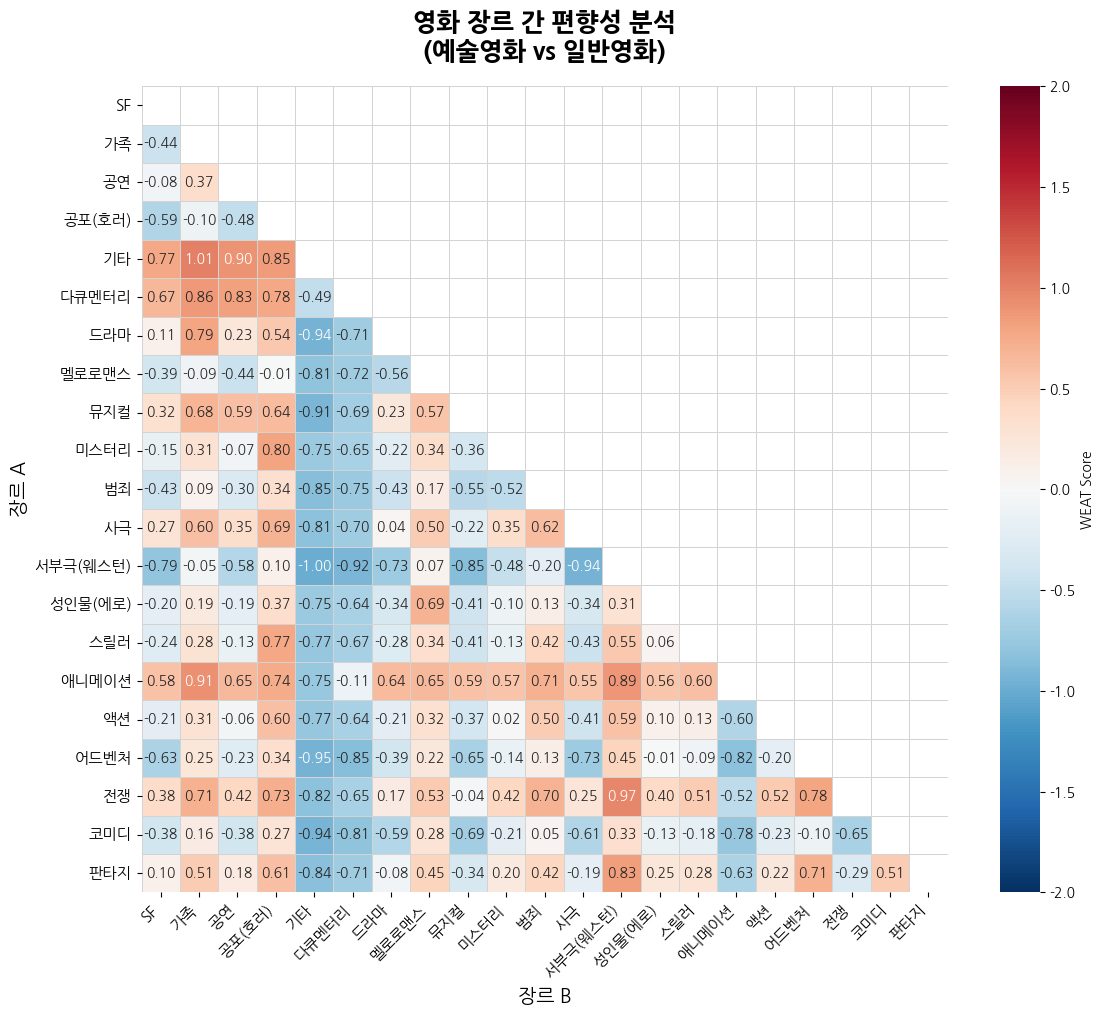

히트맵 저장 완료: weat_heatmap.png


In [24]:
# 히트맵 시각화
plt.figure(figsize=(12, 10))

# 상삼각 마스킹 (대각선 포함)
mask = np.triu(np.ones_like(weat_matrix_df, dtype=bool))

sns.heatmap(weat_matrix_df,
            annot=True,
            fmt='.2f',
            cmap='RdBu_r',
            center=0,
            vmin=-2, 
            vmax=2,
            mask=mask,
            cbar_kws={'label': 'WEAT Score'},
            linewidths=0.5,
            linecolor='lightgray',
            square=True)

plt.title('영화 장르 간 편향성 분석\n(예술영화 vs 일반영화)', fontsize=18, pad=20, weight='bold')
plt.xlabel('장르 B', fontsize=14)
plt.ylabel('장르 A', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=11)
plt.yticks(rotation=0, fontsize=11)
plt.tight_layout()
plt.savefig(data_dir+'weat_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("히트맵 저장 완료: weat_heatmap.png")

In [25]:
# 상위/하위 편향성 분석

# 절대값 기준 정렬
weat_df['abs_score'] = weat_df['weat_score'].abs()
weat_sorted = weat_df.sort_values('abs_score', ascending=False)

print("\n=== TOP 10: 가장 강한 편향성 ===")
for idx, row in weat_sorted.head(10).iterrows():
    print(f"{row['genre_A']} vs {row['genre_B']}: {row['weat_score']:.3f}")

print("\n=== BOTTOM 10: 가장 약한 편향성 ===")
for idx, row in weat_sorted.tail(10).iterrows():
    print(f"{row['genre_A']} vs {row['genre_B']}: {row['weat_score']:.3f}")


=== TOP 10: 가장 강한 편향성 ===
가족 vs 기타: 1.005
기타 vs 서부극(웨스턴): -0.998
서부극(웨스턴) vs 전쟁: 0.970
기타 vs 어드벤처: -0.946
기타 vs 드라마: -0.941
사극 vs 서부극(웨스턴): -0.940
기타 vs 코미디: -0.936
다큐멘터리 vs 서부극(웨스턴): -0.921
가족 vs 애니메이션: 0.914
기타 vs 뮤지컬: -0.910

=== BOTTOM 10: 가장 약한 편향성 ===
공연 vs 미스터리: -0.069
공연 vs 액션: -0.059
성인물(에로) vs 스릴러: 0.059
가족 vs 서부극(웨스턴): -0.052
범죄 vs 코미디: 0.047
뮤지컬 vs 전쟁: -0.042
드라마 vs 사극: 0.038
미스터리 vs 액션: 0.015
성인물(에로) vs 어드벤처: -0.013
공포(호러) vs 멜로로맨스: -0.006


## 결론

- 강한 편향성 발견:

  WEAT Score 절댓값 0.8 이상의 강한 효과 크기를 보이는 장르 조합이 다수 발견되었다. 이는 모델이 두 영화군을 명확하게 구분하여 학습했음을 나타낸다.
  * 예술영화는 '가족', '드라마', '서부극(웨스턴)' 등의 서사 중심 장르와 강한 연관성을 보였다.
  * 일반영화는 '기타'(상업적/복합 장르), '애니메이션' 등의 대중적 장르 키워드와 더 밀접한 연관성이 있었다.      


- 약한 편향성 (중립 영역):

  '공포(호러) vs 멜로로맨스' 조합은 Score가 0.0에 근접하여, 두 장르가 예술/일반 영화 시놉시스 전반에 걸쳐 비교적 고르게 분포되어 있음을 확인했다. 이 두 가지 오락적인 장르가 예술영화와 일반영화를 구분하는 데 있어 별 변별력이 없다는 점이 흥미로웠다.

## 회고

- Word2Vec 기반 임베딩과 WEAT 산출을 잘 끝내서 뿌듯하다. 
- 더 정교한 불용어 및 고유명사 처리를 했다면 WEAT score 의 신뢰도를 더 높일 수 있었을 것 같다.
- 순열 검정(Permutation Test)을 통한 p-value를 계산하지 않아 도출된 편향성이 통계적으로 유의미한지 객관적으로 증명하는 데 한계가 있었다.
- 참고 문헌: Aylin Caliskan 외 2인, Semantics derived automatically from language corpora contain human-like biases [[paper](https://arxiv.org/pdf/1608.07187)]